In [11]:
import scipy.io as sio
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from node2vec import Node2Vec
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
import random
import matplotlib.colors as colors_module

## Wczytuję plik danych z facebooka. Wierzchołki to osoby, a krawędź oznacza że 2 osoby są znajomymi. Jest to graf nie skierowany.

In [2]:
matrix = sio.mmread("socfb-Harvard1.mtx").tocoo()
edges = list(set((min(u, v), max(u, v)) for u, v in zip(matrix.row, matrix.col)))
G = nx.Graph()
G.add_edges_from(edges)

In [3]:
print(f"Liczba wierzchołków: {G.number_of_nodes()}, krawędzi: {G.number_of_edges()}")

Liczba wierzchołków: 15126, krawędzi: 824617


## Pracuję jedynie na 1000 wierzchołkach wybranych z głównej składowej, ponieważ nie mam dużo mocy obliczeniowej

In [4]:
# Znalezienie największej spójnej składowej
largest_cc = max(nx.connected_components(G), key=len)
SG = G.subgraph(largest_cc).copy()

#np. 1000 wierzchołków
sample_nodes = random.sample(list(SG.nodes), 1000)
SG = SG.subgraph(sample_nodes).copy()


## 2 Wybrane sposoby reprezentacji wizualnej tego podgrafu

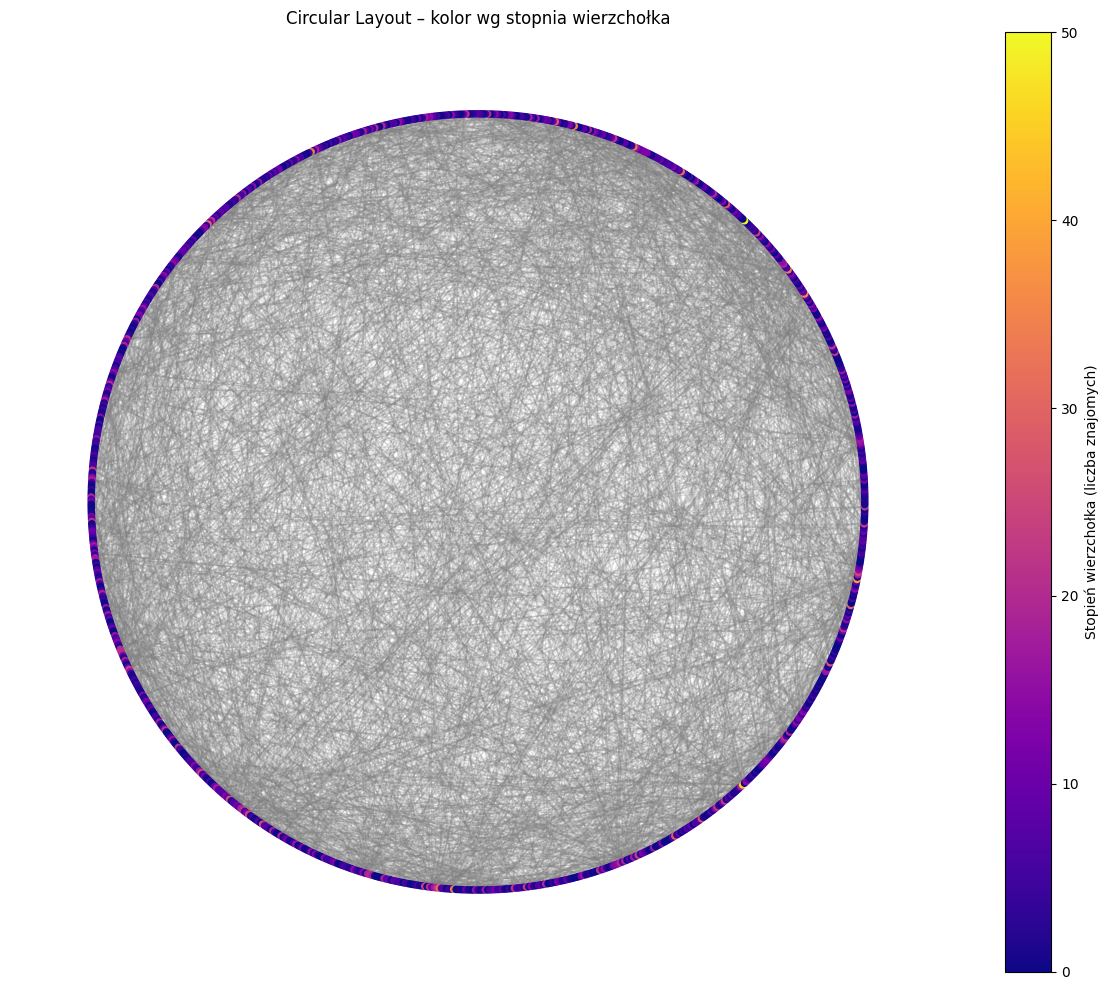

In [13]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors_module
import matplotlib.cm as cm
import numpy as np

positions_circular = nx.circular_layout(SG)

# Kolorowanie wg stopnia
degrees = dict(SG.degree())
node_degrees = np.array([degrees[n] for n in SG.nodes])
norm = colors_module.Normalize(vmin=min(node_degrees), vmax=max(node_degrees))
cmap = plt.get_cmap('plasma')  # poprawiona wersja get_cmap

# Kolory wierzchołków
node_colors = [cmap(norm(degrees[n])) for n in SG.nodes]

fig, ax = plt.subplots(figsize=(12, 10))

nx.draw_networkx_edges(SG, pos=positions_circular, alpha=0.2, edge_color='gray', ax=ax)
nodes = nx.draw_networkx_nodes(SG, pos=positions_circular, node_color=node_colors, node_size=20, ax=ax)

# Legenda
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Stopień wierzchołka (liczba znajomych)")

ax.set_title("Circular Layout – kolor wg stopnia wierzchołka")
ax.axis('off')
plt.tight_layout()
plt.show()


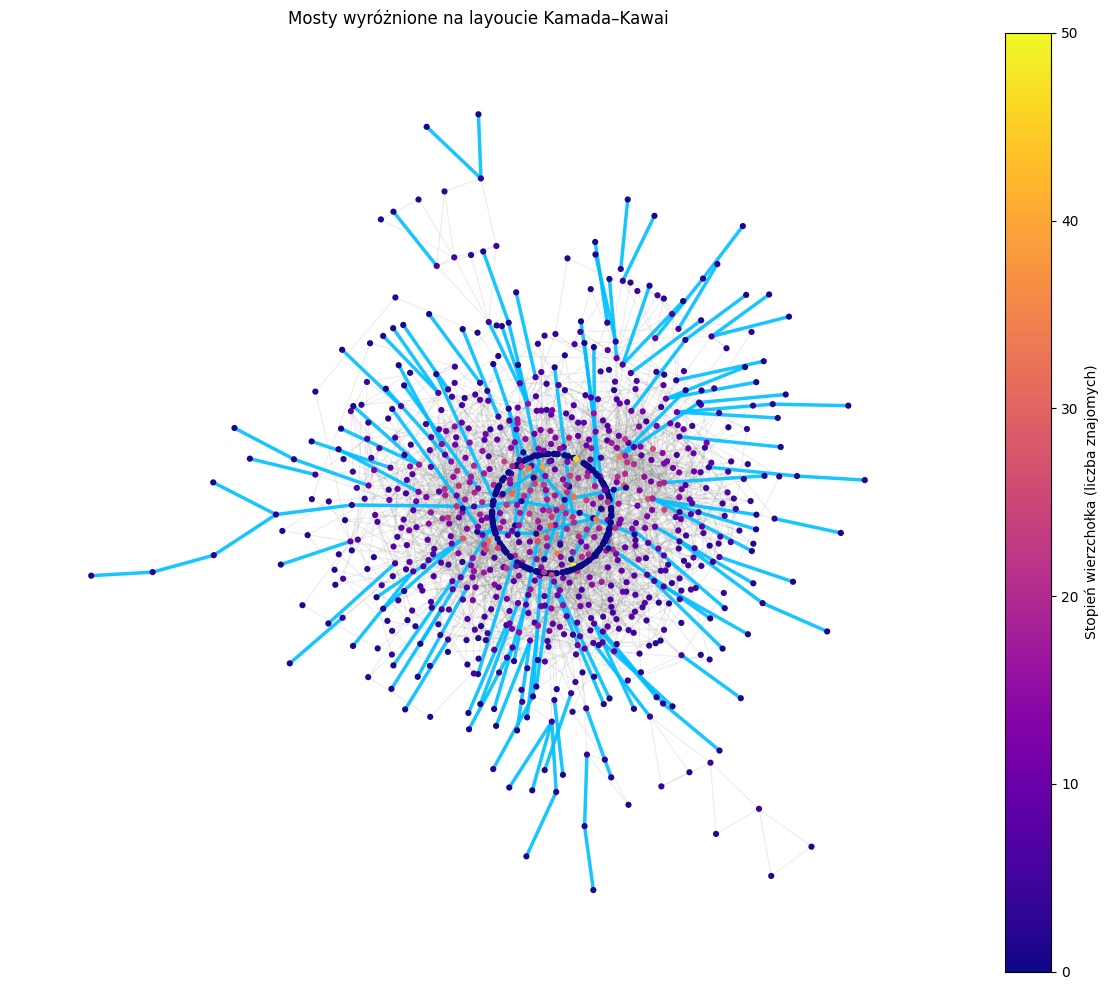

In [14]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors_module
import numpy as np

positions_kk = nx.kamada_kawai_layout(SG, scale=10)

deg = dict(SG.degree())
node_degrees = np.array([deg[n] for n in SG])
norm = colors_module.Normalize(vmin=node_degrees.min(),
                               vmax=node_degrees.max())
cmap = plt.get_cmap('plasma')
node_colors = [cmap(norm(deg[n])) for n in SG]

# wyłuskanie mostów
bridge_edges   = set(nx.bridges(SG))            # {(u,v), …}
other_edges    = [e for e in SG.edges if e not in bridge_edges
                                      and (e[1],e[0]) not in bridge_edges]


fig, ax = plt.subplots(figsize=(12,10))

# zwykłe krawędzie
nx.draw_networkx_edges(
        SG, pos=positions_kk, edgelist=other_edges,
        edge_color='gray', alpha=0.15, width=0.8, ax=ax)

# mosty – pogrubione i w kontrastowym kolorze
nx.draw_networkx_edges(
        SG, pos=positions_kk, edgelist=list(bridge_edges),
        edge_color='deepskyblue', width=2.5, ax=ax, alpha=0.9)

# węzły
nx.draw_networkx_nodes(
        SG, pos=positions_kk, node_color=node_colors,
        node_size=20, ax=ax, linewidths=0)

sm = cm.ScalarMappable(cmap=cmap, norm=norm);  sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Stopień wierzchołka (liczba znajomych)")

ax.set_title("Mosty wyróżnione na layoucie Kamada–Kawai")
ax.axis('off')
plt.tight_layout()
plt.show()


### Na samym środku rysunku widzimy dziwny okrąg ułożony z wierzchołków - prawdopodobnie algorytm Kamada-Kawai słabo radzi sobie z wizualizacją dużej liczby wierzchołków na ryskunku. Jest to algorytm siłowy, przez co powstaje ta 'anomalia'

## Stosuję embedding z Node2Vec
Zamieniam wierzchołki na wektory w nowej przestrzeni.

In [5]:
# Embedding z Node2Vec + t-SNE
print("embedding...")
node2vec = Node2Vec(G, dimensions=64, walk_length=20, num_walks=20, workers=1)
model = node2vec.fit(window=10, min_count=1, batch_words=256)


embedding...


Computing transition probabilities:   0%|          | 0/15126 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 20/20 [01:47<00:00,  5.37s/it]


In [15]:
# pokazuję dla największej wspólnej skłądowej
embedding_vectors = np.array([model.wv[str(n)] for n in sample_nodes])

## Redukuję wymiarowość używając tsne aby uchwycić jak najwięcej informacji ale wyświetlić to w 2d

In [16]:
# Redukcja do 2 mymiarów za pomocą tsne
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embedding_2d = tsne.fit_transform(embedding_vectors)

In [17]:
scaler = MinMaxScaler()
embedding_2d = scaler.fit_transform(embedding_2d)

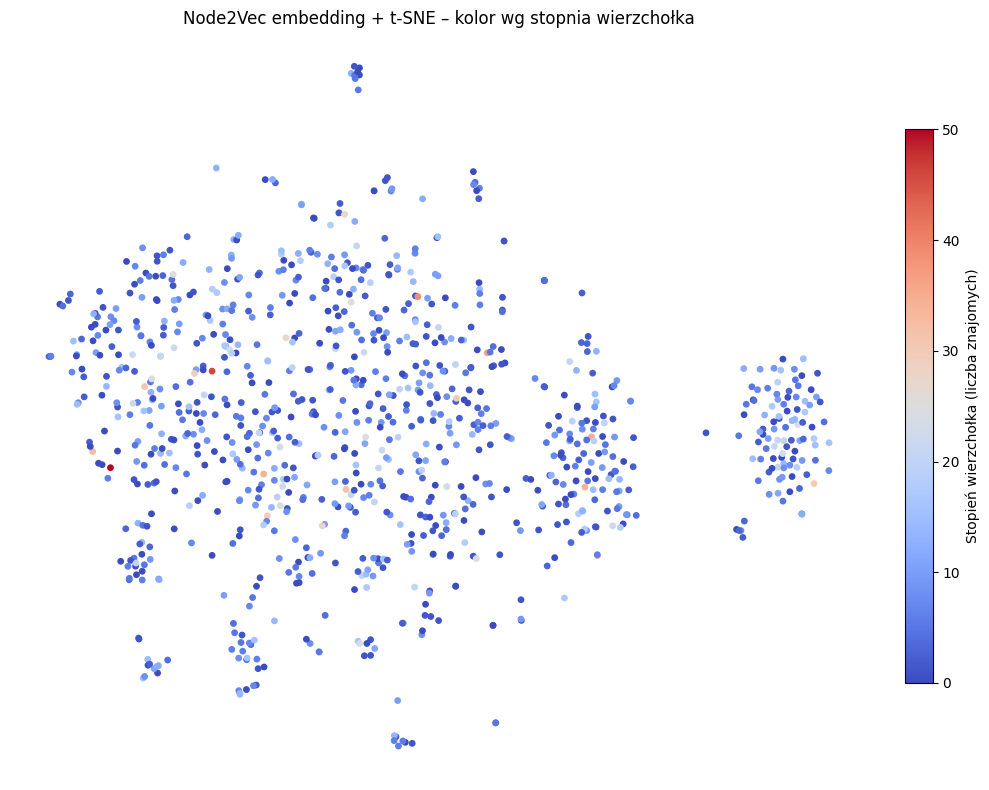

In [20]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Przykład przypisania wartości 'colors' (np. stopień węzła)
colors = node_degrees # 'node_degrees' to lista stopni węzłów w grafie

norm = mcolors.Normalize(vmin=min(colors), vmax=max(colors))

fig, ax = plt.subplots(figsize=(10, 8))
sc = ax.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=colors, cmap='coolwarm', norm=norm, s=15)



ax.set_title("Node2Vec embedding + t-SNE – kolor wg stopnia wierzchołka")
ax.axis('off')

cbar = fig.colorbar(sc, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label("Stopień wierzchołka (liczba znajomych)")

plt.tight_layout()
plt.show()



### Widzimy, że można wyodrębnić kilka grup w których punkty są blisko siebie. Oznacza to że te wierzchołki (osoby) mają np. tych samych znajomych, spędzają czas z tymi ludźmi
### Punkty oddalone od reszty - przy krawędziach obrazka to osoby które prawdopodobnie mają mało znajomych i wolą spędzać czas samemu. Należy jednak pamiętać że wybrałem jedynie 1000 z puli 15000 wierzchołków, co oznacza że to tylko próbka i wyniki mogę się różnić od wyników w całej populacji.